In [1]:
# Standard library imports
import random
import time

# Third-party imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import pathlib
from data_utils import *
from preprocessing import *
from util_functions import *

In [2]:
(u_features, v_features, adj_train, train_labels, train_u_indices, train_v_indices, val_labels, 
val_u_indices, val_v_indices, test_labels, test_u_indices, test_v_indices, class_values
) = load_official_trainvaltest_split('ml_100k', testing=True)

User features shape: (943, 23)
Item features shape: (1682, 18)


In [3]:
train_dataset = eval('MyDynamicDataset')(root='data/ml_100k/testmode/train', A=adj_train, 
    links=(train_u_indices, train_v_indices), labels=train_labels, h=1, sample_ratio=1.0, 
    max_nodes_per_hop=200, u_features=None, v_features=None, class_values=class_values)
# len(train_dataset), len(test_dataset)

In [5]:
test_dataset = eval('MyDataset')(root='data/ml_100k/testmode/test', A=adj_train, 
    links=(test_u_indices, test_v_indices), labels=test_labels, h=1, sample_ratio=1.0, 
    max_nodes_per_hop=200, u_features=None, v_features=None, class_values=class_values)

RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [2]:
base_dir = pathlib.Path().resolve()
datasets_path = f'{base_dir}/ml-latest-small'
links_df = pd.read_csv(f'{datasets_path}/links.csv')
print(links_df.shape)
movies_df = pd.read_csv(f'{datasets_path}/movies.csv')
print(movies_df.shape)
ratings_df = pd.read_csv(f'{datasets_path}/ratings.csv')
print(ratings_df.shape)
tags_df = pd.read_csv(f'{datasets_path}/tags.csv')
print(tags_df.shape)

(9742, 3)
(9742, 3)
(100836, 4)
(3683, 4)


In [3]:
# ratings_df.groupby(ratings_df['rating']).count()
ratings_df.groupby(['rating'])['rating'].count()

rating
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: rating, dtype: int64

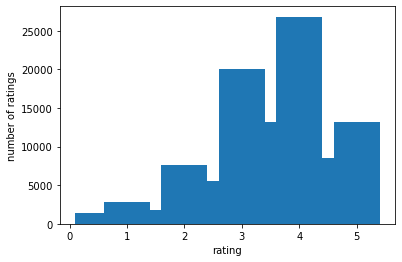

In [4]:
plt.bar([i*0.5 for i in range(1, 11)], np.array(ratings_df.groupby(['rating'])['rating'].count()))
plt.xlabel('rating')
plt.ylabel('number of ratings')
plt.show()

In [5]:
genres_title_list = ["Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", 
    "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western", "(no genres listed)"]

def find_genres_columns(current_genres, genres_title_list):
    temp_list = []
    for genre in genres_title_list:
        if genre in current_genres:
            temp_list.append(1)
        else:
            temp_list.append(0)
    temp_list = np.array(temp_list)
    return temp_list

temp = movies_df.copy(deep=True)
year_list = []
name_list = []
genres_list = []
for row in temp.values:
    id = row[0]
    name = str(row[1]).strip()
    name_inx = str(name).find('(')
    year = name[-5:-1]
    try:
        year = int(year)
    except Exception as e:
        year = -1
    genres = row[2].split('|')
    genres = find_genres_columns(genres, genres_title_list)
    genres_list.append(genres)
    name = name[:name_inx-1].replace('(', '').replace(')', '')
    year_list.append(year)
    name_list.append(name)
genres_list = np.array(genres_list)
year_list = np.array(year_list)
name_list = np.array(name_list)
temp['title'] = name_list
temp['year'] = year_list
temp['genres'] = list(genres_list)
for i, genre in enumerate(genres_title_list):
    temp[genre] = genres_list[:, i]

temp = temp[temp['(no genres listed)'] == 0]
del temp['(no genres listed)']
temp.head()

,movieId,title,genres,year,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,"[0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1995,0,1,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,2,Jumanji,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1995,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1995,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1995,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1995,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
torch.manual_seed(123)
device = torch.device('cpu')
if torch.cuda.is_available():
    torch.cuda.manual_seed(123)
    torch.cuda.synchronize()
    device = torch.device('cuda')
device

device(type='cpu')

In [2]:
device

NameError: name 'device' is not defined